In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [46]:
import tensorflow_datasets as tfds

malaria_dataset, metadata = tfds.load('malaria', with_info=True, as_supervised=True)

print(metadata)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [47]:
malaria_dataset['train']

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

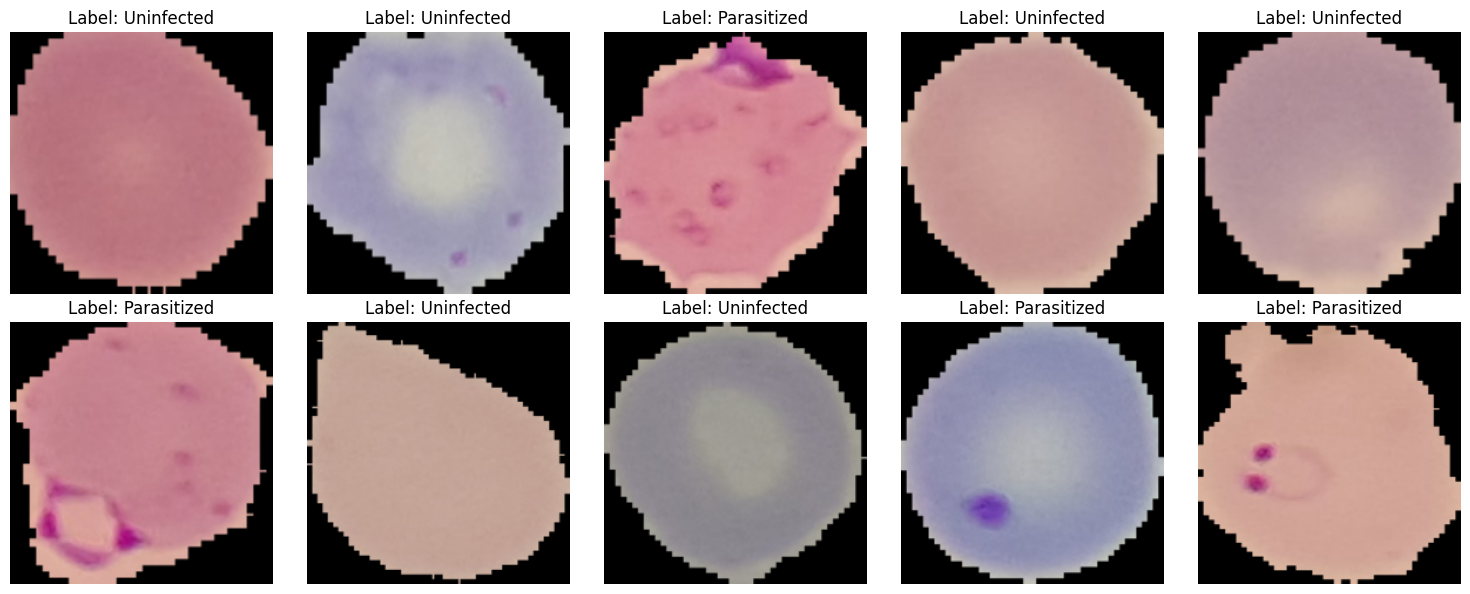

In [48]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = ax.ravel()

# Load first 10 examples
for i, example in enumerate(malaria_dataset['train'].take(10)):
    image = example[0]
    label = example[1]

    # Resize image for consistent display
    image = tf.image.resize(image, [224, 224])

    # Plot image and set title to the corresponding label
    ax[i].imshow(image.numpy().astype("uint8"))
    ax[i].title.set_text(f'Label: {"Parasitized" if label==0 else "Uninfected"}')
    # Hide axes for visual appeal
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [49]:
for image, label in malaria_dataset['train'].take(10):
    print("Image shape: ", image.numpy().shape)

Image shape:  (103, 103, 3)
Image shape:  (106, 121, 3)
Image shape:  (139, 142, 3)
Image shape:  (130, 118, 3)
Image shape:  (121, 109, 3)
Image shape:  (127, 121, 3)
Image shape:  (166, 151, 3)
Image shape:  (145, 139, 3)
Image shape:  (139, 142, 3)
Image shape:  (172, 145, 3)


In [50]:
# Split dataset to train, val and test

malaria_dataset = malaria_dataset['train'].shuffle(buffer_size=10000)
n = len(malaria_dataset)

TRAIN_SIZE = int(0.75 * n)
VAL_SIZE = int(0.15 * n)

train_data = malaria_dataset.take(TRAIN_SIZE)
remaining_data = malaria_dataset.skip(TRAIN_SIZE)
val_data = remaining_data.take(VAL_SIZE)
test_data = remaining_data.skip(VAL_SIZE)

In [51]:
def preprocess_image(image, label):
    layers = keras.Sequential([keras.layers.Resizing(224,224), keras.layers.Rescaling(1/255)])
    image = layers(image)
    return image, label

train_data = train_data.map(preprocess_image)
val_data = val_data.map(preprocess_image)
test_data = test_data.map(preprocess_image)

In [52]:
for image, label in train_data.take(10):
    print("Image shape: ", image.shape)

Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)


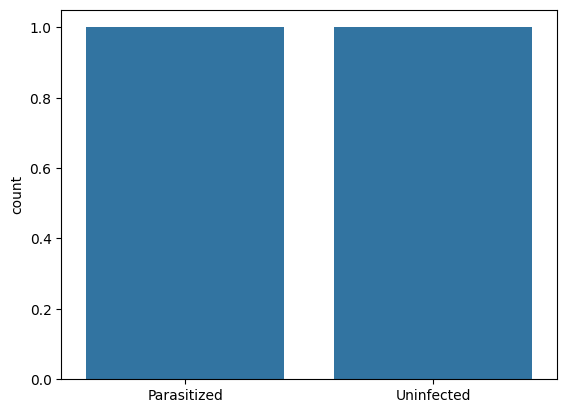

In [55]:
import seaborn as sns
# Class distribution in train data
labels = {'Parasitized':0, 'Uninfected':0}
for image, label in train_data:
    if label==0:
        labels['Parasitized']+=1
    else:
        labels['Uninfected']+=1

sns.countplot(labels)
plt.show()

In [56]:
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

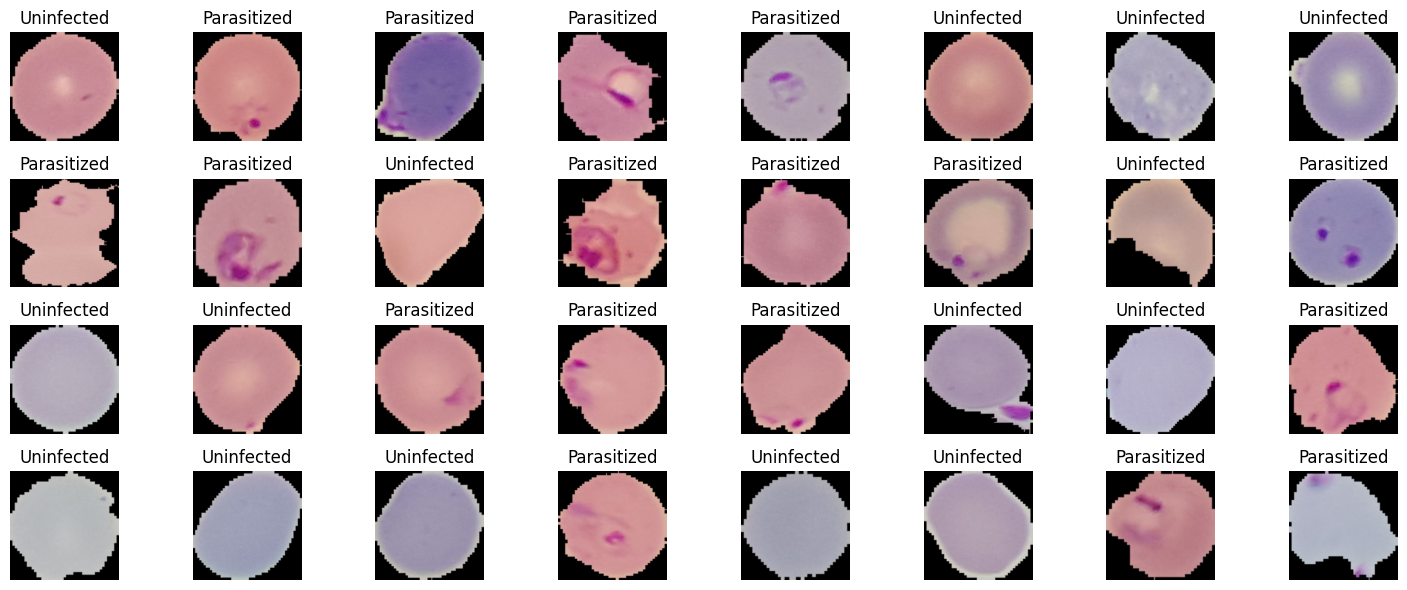

In [58]:
# Visualize 1 batch
image_batch, label_batch = next(iter(train_data))

fig, ax = plt.subplots(4, 8, figsize=(15, 6))
ax = ax.ravel()
i = 0
for image, label in zip(image_batch, label_batch):
    ax[i].imshow(image)
    ax[i].title.set_text(f'{"Parasitized" if label==0 else "Uninfected"}')
    # Hide axes for visual appeal
    ax[i].axis('off')
    i+=1

plt.tight_layout()
plt.show()

In [82]:
import keras.backend as K

K.clear_session()

def build_model(input_shape=(224,224,3)):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # First block
    x = keras.layers.Conv2D(32, 3, activation='relu',padding='same')(inputs)
    x = keras.layers.Conv2D(64, 3, activation='relu',padding='same')(x)
    # x = keras.layers.BatchNormalization()(x)
    block_1_output = keras.layers.MaxPooling2D(3)(x)

    # Second block with a residual connection
    x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
    x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    # x = keras.layers.BatchNormalization()(x)
    block_2_output = keras.layers.add([x, block_1_output])

    # Third block with a residual connection
    x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
    x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    # x = keras.layers.BatchNormalization()(x)
    block_3_output = keras.layers.add([x, block_2_output])

    # Final layers including the output layer
    x = keras.layers.Conv2D(256, 3, activation='relu')(block_3_output)
    x = keras.layers.MaxPooling2D(3)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    return model

In [83]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         18496     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [14]:
# Detect TPU and initialize
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)  # Create TPU strategy
    print("TPU initialized successfully.")
except ValueError as e:
    print("Failed to initialize TPU. Ensure TPU is selected as hardware accelerator.")
    tpu_strategy = None

# Check TPU devices
print("TPU Devices:", tf.config.list_logical_devices('TPU'))


TPU initialized successfully.
TPU Devices: [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [84]:
with tpu_strategy.scope():
    model = build_model()
    METRICS = ['binary_accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=METRICS)
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
            train_data,
            epochs = 50,
            validation_data = val_data,
            callbacks=callbacks
          )

Epoch 1/50
646/646 [==============================] - 41s 49ms/step - loss: 0.7014 - binary_accuracy: 0.5610 - precision: 0.5476 - recall: 0.7094 - val_loss: 0.6880 - val_binary_accuracy: 0.5316 - val_precision: 0.5236 - val_recall: 0.9566
Epoch 2/50
646/646 [==============================] - 28s 42ms/step - loss: 0.6660 - binary_accuracy: 0.5995 - precision: 0.5855 - recall: 0.6654 - val_loss: 0.6821 - val_binary_accuracy: 0.5563 - val_precision: 0.5452 - val_recall: 0.8190
Epoch 3/50
646/646 [==============================] - 27s 41ms/step - loss: 0.6756 - binary_accuracy: 0.6115 - precision: 0.5889 - recall: 0.7341 - val_loss: 0.6895 - val_binary_accuracy: 0.5144 - val_precision: 0.5043 - val_recall: 0.9431
Epoch 4/50
646/646 [==============================] - 27s 41ms/step - loss: 0.6661 - binary_accuracy: 0.5800 - precision: 0.5656 - recall: 0.6997 - val_loss: 0.5852 - val_binary_accuracy: 0.6876 - val_precision: 0.6305 - val_recall: 0.8988
Epoch 5/50
646/646 [====================

In [ ]:
# Plot loss and accuracy curves
history.history[]

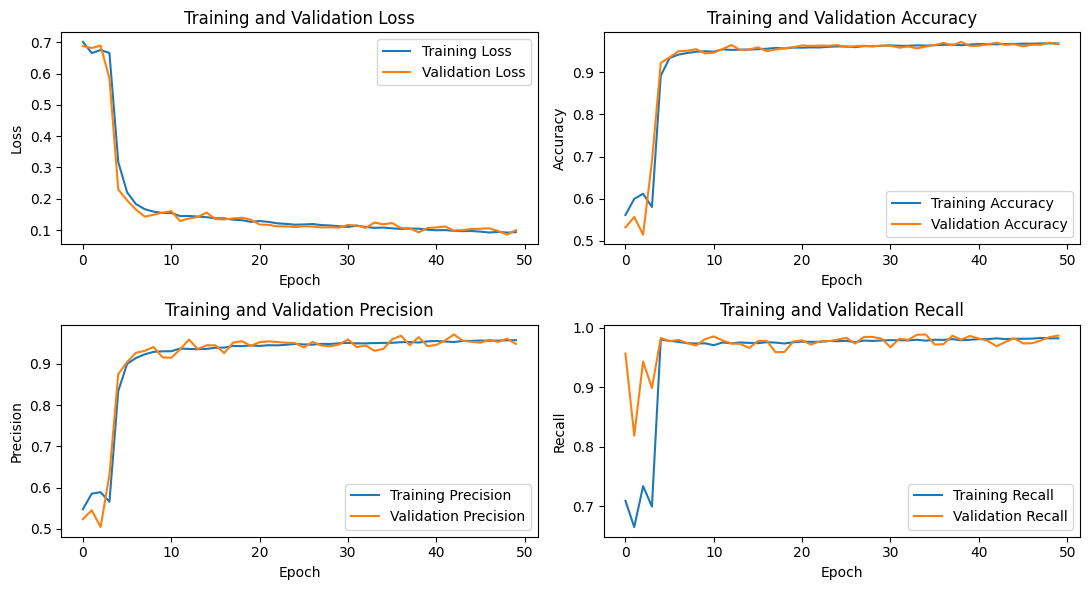

In [91]:
# Plot loss, accuracy, precision, and recall
fig, ax = plt.subplots(2, 2, figsize=(11, 6))

# Plot loss
ax[0, 0].plot(history.history['loss'], label='Training Loss')
ax[0, 0].plot(history.history['val_loss'], label='Validation Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0, 0].set_title('Training and Validation Loss')

# Plot accuracy
ax[0, 1].plot(history.history['binary_accuracy'], label='Training Accuracy')
ax[0, 1].plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].legend()
ax[0, 1].set_title('Training and Validation Accuracy')

# Plot precision
ax[1, 0].plot(history.history['precision'], label='Training Precision')
ax[1, 0].plot(history.history['val_precision'], label='Validation Precision')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Precision')
ax[1, 0].legend()
ax[1, 0].set_title('Training and Validation Precision')

# Plot recall
ax[1, 1].plot(history.history['recall'], label='Training Recall')
ax[1, 1].plot(history.history['val_recall'], label='Validation Recall')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Recall')
ax[1, 1].legend()
ax[1, 1].set_title('Training and Validation Recall')

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
model.evaluate(test_data)

87/87 [==============================] - 4s 22ms/step - loss: 0.0933 - binary_accuracy: 0.9684 - precision: 0.9518 - recall: 0.9851


[0.09332463890314102,
 0.9684439897537231,
 0.9517638683319092,
 0.9850968718528748]

In [ ]:
# Load model
model = keras.models.load_model('malaria_model.h5', compile=False)
METRICS = ['binary_accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=METRICS)

In [195]:
image = cv2.imread("parasitized/C33P1thinF_IMG_20150619_114756a_cell_182.png")
image.shape

(154, 157, 3)

In [196]:
def get_model_prediction(model, image):
    layers = keras.Sequential([keras.layers.Resizing(224,224), keras.layers.Rescaling(1/255)])
    image = layers(image)
    image = tf.expand_dims(image, axis = 0)
    pred = model.predict(image)
    return pred[0]

score = get_model_prediction(model, image)

if score<0.5:
    print("parasitized")
else:
    print("uninfected")

1/1 [==============================] - 0s 10ms/step
parasitized


In [197]:
def preprocess_query_image(image):
    layers = keras.Sequential([keras.layers.Resizing(224,224), keras.layers.Rescaling(1/255)])
    image = layers(image)
    return image

image = preprocess_image(image)
image.shape

TensorShape([224, 224, 3])

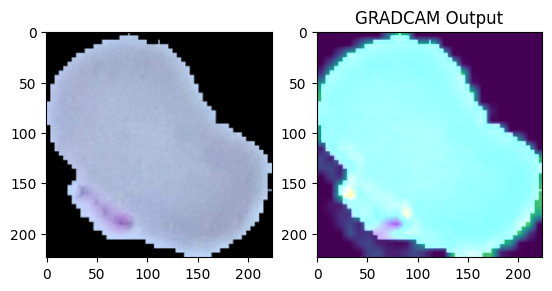

In [198]:
from tf_explain.core.grad_cam import GradCAM


# Start explainer
explainer = GradCAM()
input_image = np.expand_dims(image,0)

grid = explainer.explain((input_image, None), model, class_index=0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid, cmap='jet')
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()